In [1]:
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import numpy as np

In [2]:
data_tumor = "BRCA_Primary_Tumor.chr19.tsv"
data_normal = "BRCA_Solid_Tissue_Normal.chr19.tsv"

In [3]:
# read data
tumor = pd.read_csv(data_tumor, delimiter="\t")
tumor = tumor.reset_index().rename(columns={"index":"location"})
tumor

,location,Unnamed: 0,6005486021_R01C01,6005486021_R02C01,6005486021_R03C01,6005486021_R04C01,6005486021_R05C01,6005486021_R06C01,6005486021_R01C02,6005486021_R02C02,...,6285633072_R02C02,6285633072_R04C02,6285633072_R03C02,6285633072_R05C02,7786923102_R06C02,7796806109_R01C01,7796806109_R05C01,7796806109_R06C01,7796806109_R04C01,7796806109_R02C01
0,0,cg15886596,10,10,7,7,7,7,8,6,...,13,14,11,12,13,13,12,11,12,12
1,1,cg12261117,61,44,40,30,39,30,37,38,...,45,50,41,41,74,71,72,52,63,48
2,2,cg18110419,442,617,652,689,658,636,607,514,...,665,565,608,596,701,488,625,639,701,508
3,3,cg25433760,521,976,960,979,950,971,977,969,...,965,964,953,958,962,973,976,978,973,974
4,4,cg23278040,162,486,760,224,818,561,549,715,...,462,207,54,270,366,384,788,434,592,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24666,24666,cg23652859,66,702,683,724,654,677,580,648,...,396,848,370,444,491,424,324,594,446,288
24667,24667,cg03567148,962,990,974,969,991,978,981,979,...,946,934,926,950,973,911,928,957,955,952
24668,24668,cg13678479,959,964,972,972,970,966,959,969,...,967,954,920,968,948,941,939,955,943,950
24669,24669,cg05617300,990,988,990,987,988,988,989,988,...,982,986,985,984,980,985,984,987,983,980


In [4]:
tumor_patients = tumor.columns[2:]

In [5]:
normal = pd.read_csv(data_normal, delimiter="\t")
normal = normal.reset_index().rename(columns={"index":"location"})
normal

,location,Unnamed: 0,6005486025_R04C01,6005486025_R02C01,6005486025_R03C01,6005486025_R01C01,6005486025_R06C01,6005486011_R03C01,6005486011_R04C01,6005486011_R01C02,...,6042324006_R05C02,6057833134_R03C02,6057833134_R04C02,6057833159_R05C02,6057833166_R01C01,6057833166_R03C01,6285633051_R02C01,6057833155_R06C02,6057833101_R02C01,6057833101_R06C02
0,0,cg15886596,10,8,9,9,9,7,7,8,...,8,10,12,11,12,11,9,11,10,10
1,1,cg12261117,56,38,39,59,48,37,43,46,...,72,57,67,62,67,61,40,80,65,61
2,2,cg18110419,731,665,662,698,672,734,702,661,...,928,653,710,686,640,627,767,733,684,668
3,3,cg25433760,949,958,951,964,958,971,965,970,...,899,943,959,958,932,954,974,940,941,971
4,4,cg23278040,309,267,778,625,452,600,636,598,...,449,286,512,562,558,367,692,295,288,669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24666,24666,cg23652859,91,58,190,303,74,221,283,472,...,127,100,234,195,168,315,255,104,241,377
24667,24667,cg03567148,915,862,938,971,898,968,970,947,...,752,814,892,868,908,892,951,805,827,956
24668,24668,cg13678479,973,948,966,964,978,969,993,973,...,938,946,952,957,947,954,971,948,960,953
24669,24669,cg05617300,984,988,984,986,988,991,991,990,...,978,976,978,984,979,976,987,980,980,981


In [6]:
normal_patients = normal.columns[2:]

# XGBoost for 3 best features

In [7]:
normal_T = normal[normal_patients].T
normal_T["label"] = 0
tumor_T = tumor[tumor_patients].T.sample(97)
tumor_T["label"] = 1
concated = pd.concat([normal_T, tumor_T])

In [8]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

y = concated["label"]
X = concated.drop(columns=["label"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=42,
                                              stratify=y)

In [52]:
from xgboost import XGBClassifier
sites = [14274, 9484, 24302]
xg_combined = XGBClassifier(n_estiamators=100, max_depth=10, learning_rate=1, objective='binary:logistic')
xg_combined.fit(X_train[sites], y_train)
y_pred = xg_combined.predict(X_test[sites])
accuracy, recall, precision, f1 = accuracy_score(y_pred, y_test), recall_score(y_pred, y_test), precision_score(y_pred, y_test), f1_score(y_pred, y_test)
print(f"accuracy: {accuracy:.2f}, \nrecall: {recall:.2f}, \nprecision: {precision:.2f}, \nf1: {f1:.2f}")

[22:32:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estiamators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


accuracy: 0.96, 
recall: 1.00, 
precision: 0.92, 
f1: 0.96


In [54]:
normal.loc[sites]["Unnamed: 0"].tolist()

['cg21281463', 'cg05358291', 'cg22720790']

In [55]:
sites

[14274, 9484, 24302]

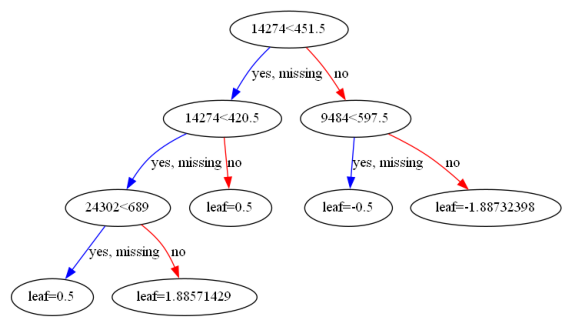

In [53]:
from xgboost import plot_tree
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


fig, ax = plt.subplots(figsize=(10, 10))
plot_tree(xg_combined,
          feature_names=normal.loc[sites]["Unnamed: 0"].tolist(), ax=ax
         )
plt.show()

In [43]:
val = 0.5
1/(1+np.exp(-1*val))

0.6224593312018546